# Imports

In [1]:
import rasterio
import geopandas as gpd
from rasterio.features import rasterize
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import xarray
import glob
from PIL import Image
from rioxarray.merge import merge_arrays
import rioxarray
import matplotlib.pyplot as plt

In [2]:
from zipfile import ZipFile
from io import BytesIO

In [3]:
import os
import requests
from datetime import datetime

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def download_tif(url, dir_path):
    response = requests.get(url, verify=False)
    if response.status_code == 200:
        with ZipFile(BytesIO(response.content)) as zip_ref:
            # Loop through each file in the zip
            for zip_info in zip_ref.infolist():
                # Extract only files, ignore directories
                if not zip_info.is_dir():
                    # Use the file name only, ignoring any directory paths in the zip file
                    zip_info.filename = os.path.basename(zip_info.filename)
                    # Extract the file with the new path
                    zip_ref.extract(zip_info.filename, path=dir_path) 
    else:
        print(f"{datetime.now()} {url} failed")

In [61]:
current_dir = os.getcwd()
DSM_dir_path = current_dir + r"\DSM"
DTM_dir_path = current_dir + r"\DTM"
RGB_DSM_dir_path = current_dir + r"\RGB_DSM"

In [62]:
def create_dir(path):
    # Check if the directory exists
    if not os.path.exists(path):
        # Create the directory if it does not exist
        os.makedirs(path)
        print(f"Directory '{path}' was created.")
    else:
        print(f"Directory '{path}' already exists.")

In [63]:
create_dir(DSM_dir_path)
create_dir(DTM_dir_path)
create_dir(RGB_DSM_dir_path)

Directory 'C:\Users\Niels\PycharmProjects\SSML-group-project\DSM' already exists.
Directory 'C:\Users\Niels\PycharmProjects\SSML-group-project\DTM' already exists.
Directory 'C:\Users\Niels\PycharmProjects\SSML-group-project\RGB_DSM' was created.


In [9]:
DSM_files = ["https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_31GN2.zip",
                "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_31HN1.zip",
                "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_31HN2.zip",
                "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_32CN1.zip",
                "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_31GZ2.zip",
                "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_31HZ1.zip",
                "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_31HZ2.zip",
                "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_32CZ1.zip",
                "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_38EN2.zip",
                "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_38FN1.zip",
                "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_38FN2.zip",
                "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/03a_DSM_0.5m/R_39AN1.zip"]

DTM_files = ["https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_31GN2.zip",
             "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_31HN1.zip",
             "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_31HN2.zip",
             "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_32CN1.zip",
             "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_31GZ2.zip",
             "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_31HZ1.zip",
             "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_31HZ2.zip",
             "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_32CZ1.zip",
             "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_38EN2.zip",
             "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_38FN1.zip",
             "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_38FN2.zip",
             "https://ns_hwh.fundaments.nl/hwh-ahn/ahn4/02a_DTM_0.5m/M_39AN1.zip"]

In [10]:
# for DSM_file in tqdm(DSM_files):
#     download_tif(DSM_file, DSM_dir_path)

In [11]:
# for DTM_file in tqdm(DTM_files):
#     download_tif(DTM_file, DTM_dir_path)

### Create RGB DSM

In [50]:
# Use glob to find all TIFF files in the directory
tif_files = glob.glob(f"{DSM_dir_path}/*.TIF")

# Load each TIFF file
DSMs = []
for file_path in tif_files:
    DSM = rioxarray.open_rasterio(file_path)
    DSMs.append(DSM)

In [51]:
# Merge all the raster datasets into one big raster
merged_DSM = merge_arrays(DSMs)

In [53]:
no_data_value = 30000

# Replace extreme values with 0
merged_DSM = merged_DSM.where(merged_DSM < no_data_value, 0)

In [55]:
merged_DSM = merged_DSM.fillna(0)

### Write files with 4 bands

In [64]:
rgb_files = glob.glob("nl_8cm/*.tif")

for rgb_file in tqdm(rgb_files):
    # Load rgb file
    rgb = rioxarray.open_rasterio(rgb_file)
    bounds = rgb.rio.bounds()
    # Slice rgb file outline from NDSM file
    sub_DSM = merged_DSM.rio.clip_box(minx=bounds[0], miny=bounds[1], maxx=bounds[2], maxy=bounds[3])
    # Upsample to same resolution as RGB images
    sub_DSM = sub_DSM.interp(y=rgb.y, x=rgb.x, method='nearest')
    # Merge RGB with DSM
    combined = xarray.concat([rgb, sub_DSM], dim='band')
    # Write R,G,B,DSM file
    filename = rgb_file.split("\\")[-1]  # Corrected: Escape the backslash or use a raw string if needed
    combined.rio.to_raster(f"RGB_DSM/{filename}")

  0%|                                                                                                                                                           | 0/66 [00:09<?, ?it/s]


MemoryError: Unable to allocate 2.33 GiB for an array with shape (4, 12500, 12500) and data type float32

In [44]:
raster = rioxarray.open_rasterio("RGB_DSM/2022_130000_456000_RGB_hrl.tif")

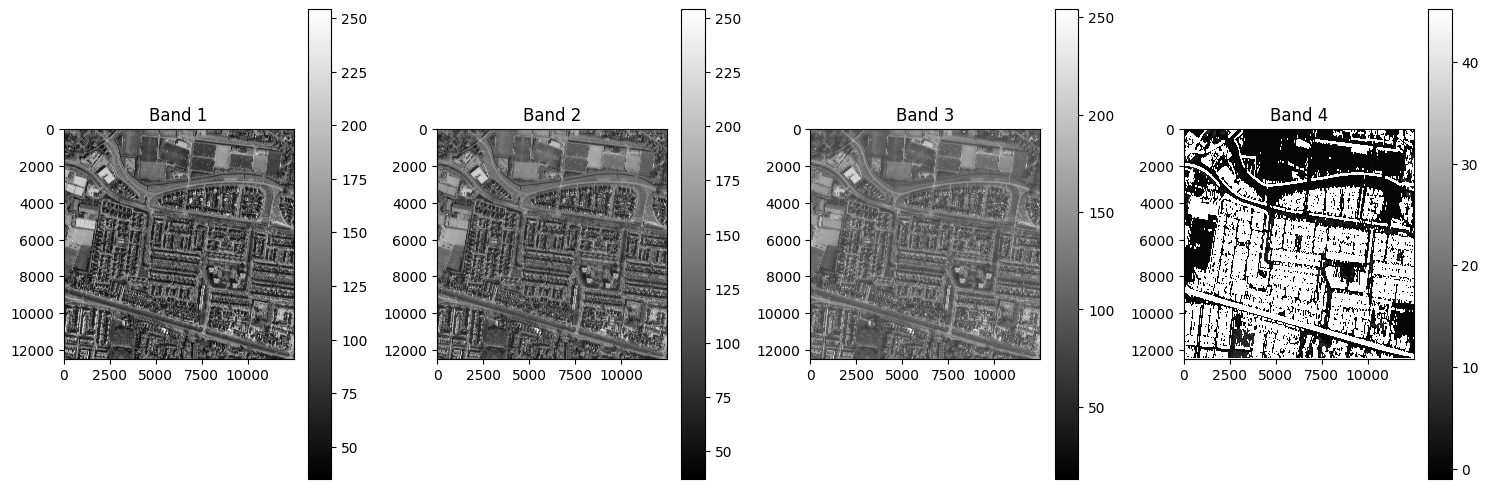

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))  # Adjust figsize as needed

for i, ax in enumerate(axs.flat):
    band_data = raster.isel(band=i)
    im = ax.imshow(band_data, cmap='gray')  # Adjust colormap as needed
    ax.set_title(f'Band {i+1}')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

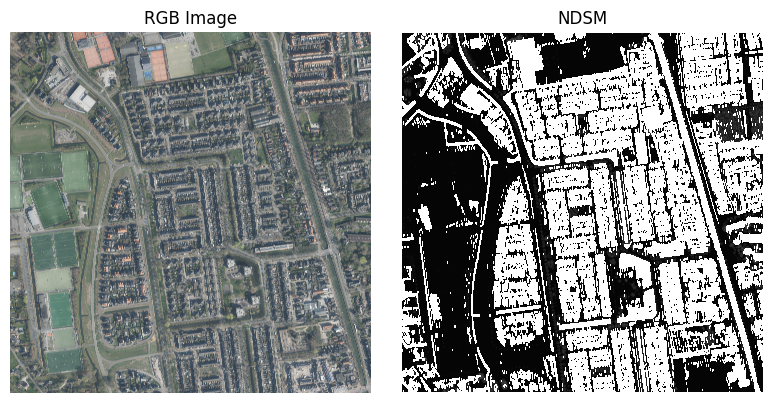

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # Create a figure and a 1x2 subplot layout

# Plot RGB array
ax[0].imshow(raster.values[:3].T / 255)
ax[0].set_title('RGB Image')
ax[0].axis('off')  # Hide axes for a cleaner look

# Plot DSM array in grayscale
ax[1].imshow(raster.values[3:].T, cmap='gray')
ax[1].set_title('DSM')
ax[1].axis('off')  # Hide axes for a cleaner look

plt.tight_layout()  # Adjust the layout so plots don't overlap
plt.show()